# DASi Submission

We pull in the output_plasmids SeqRecords and design. We output a JSON file. We then parse this file to an AqSample graph. New samples are created using trident.

Dockerized terrarium then submits the plan.

In [10]:
# login to Benchling & Aquarium
from aqbt.tools import config_to_sessions
from aqbt.tools import parse_config
import toml

def config(config_path):
    with open(config_path, "r") as f:
        return parse_config(toml.load(f))


def sessions(config):
    return config_to_sessions(config)


sessions = sessions(config('config.toml'))
sessions

{'default': {'aquarium': <AqSession(name=None, AqHTTP=<AqHTTP(user='vrana', url='http://52.27.43.242')>), parent=94261690151776)>,
  'benchling': <benchlingapi.session.Session at 0x7fa70cb45e50>,
  'registry': <aqbt.aquarium.registry.LabDNARegistry at 0x7fa70ca52910>}}

#### Post on Benchling

In [13]:
benchling = sessions['default']['benchling']
registry = sessions['default']['registry']
session = sessions['default']['aquarium']
folder = benchling.Folder.find_by_name("2020Campaign")

In [4]:
from aqbt.bioadapter import convert
from aqbt import biopython
from glob import glob

records = biopython.load_genbank_glob(glob('output_plasmids/*.gb'))

seqs = []
for record in records:
    data = convert(record, to='benchling_dna_json')
    data['folder_id'] = folder.id
    seq = benchling.DNASequence.load(data)
    seqs.append(seq)

### Collect Inventory

In [16]:
import pickle
from os.path import abspath
from os.path import dirname
from os.path import isfile
from os.path import join

from dasi import LibraryDesign

from aqbt.bioadapter import convert
from aqbt.design.dasi.dfs import KlavinsLabDnaDb


here = abspath(dirname("."))
DEFAULT_FILEPATH = join(here, "inventory.df")

from aqbt.design.dasi.dasi_to_aquarium import design_from_benchling_links, inventory_df

def inventory_df(registry=None, force_new: bool = False, filepath: str = None):
    if filepath is None:
        filepath = DEFAULT_FILEPATH
    df = None
    if isfile(filepath) and not force_new:
        with open(filepath, "rb") as f:
            try:
                return pickle.load(f)
            except Exception as e:
                print("Could not load pickled file.")
                print(e)
    if df is None:
        db = KlavinsLabDnaDb(registry)
        db.build(dna_limit=None, primer_limit=None)
        df = db.df[db.df["is_available"] == True]
        df.drop("benchling_sequence", axis=1, inplace=True)
        with open(filepath, "wb") as f:
            pickle.dump(df, f)

    # clean
    df["trashed"] = [s.name.lower().startswith("trashed") for s in df["sample"]]
    df = df[df["is_available"] == True]
    df = df[~df["trashed"]]
    return df

df = inventory_df(sessions['default']['registry'])

In [17]:
df.to_csv("InventoryDataFrame.csv")

#### DASi Submission

In [9]:
df = df[df['is_available'] == True]
# df = df[~df['trashed']]

def _get_records(st):
    return list(df[df["sample_type"] == st]["record"])

fragments = _get_records('Fragment')
plasmids = _get_records("Plasmid")
primers = _get_records("Primer")


biopython.make_cyclic(records)
biopython.make_linear(fragments)
biopython.make_linear(primers)
biopython.make_linear(plasmids)

design = LibraryDesign()
design.FAVOR_SHARED_SEQUENCES = 10.0
design.add_materials(
    primers=primers, fragments=fragments, templates=plasmids, queries=records
)
design.logger.set_level("DEBUG")
design.run(n_paths=1, n_jobs=6)

  0%|          | 0/5 [00:00<?, ?it/s]

INFO - ProgressLoggable(LibraryDesign(id=140353959442368)) - 2020-07-21 06:17:56,566 - Running blast
Found previous installation at "/home/justin/anaconda3/envs/aqbt/lib/python3.8/site-packages/pyblast/blast_bin/bin/ncbi-blast-2.10.1+/bin"


KeyboardInterrupt: 

In [ ]:
design.out(elim_extra_reactions=True)

In [ ]:
design.report().plot_coverage(show=True)

## DASi Output to Aquarium

In [15]:
output = design.out(elim_extra_reactions=True)

### Aquarium Sample Recycler

This class recycles samples that have been `trashed` (aka have "TRASHED" prefixed in their name).

Call `recycler = SampleRecycler(session)` to create a new instance. 

To grab a trashed sample, call `recycler.reuse(sample_type_id)` to choose a trashed sample. A valid trashed sample
should have no items, should not be used in any planned operation as an input, should not be used as a property in any field value for a non-trashed sample, and should have no field value properties.

To trash a new sample, `recycler.trash_sample(sample)` which will append "TRASHED" prefix to its name and delete all of its field values.

In [21]:
class SampleRecycler(object):
    
    TRASHED = 'TRASHED'
    USER_ID = 66
    
    def __init__(self, session):
        self.session = session()
        self.session.browser.model_cache = {}
        self.session.using_cache = False
        self._reused = []
        self._trash = None
    
    @classmethod
    def allowed(cls, sample, do_raise: bool = True):
        if sample.user_id != cls.USER_ID:
            if do_raise:
                raise ValueError("Opps! Cannot access other users samples!")
            else:
                return False
        return True
    
    @classmethod
    def is_trashed(cls, sample):
        if not cls.allowed(sample, do_raise=False):
            return False
        elif sample.name.startswith(cls.TRASHED):
            return True
        return False
    
    def trash_sample(self, sample):
        if not self.can_be_trashed(sample):
            print("Cannot trash sample")
            return
        if not self.is_trashed(sample):
            sample.name = "TRASHED__" + sample.name
            sample.description = json.dumps({
                'is_trashed': True,
                'trashed_on': str(arrow.now()),
                'previous_name': sample.name
            })
            
            self.clear_field_values(sample)
            self.trash.append(sample)
            try:
                sample.save()
            except:
                sample.name += str(uuid4())[-6:]
                sample.save()
        
    def iter_trash(self):
        for s in self.session.Sample.where({'user_id': self.USER_ID}):
            if self.is_trashed(s):
                if s.user_id != self.USER_ID:
                    raise ValueError("Opps! Cannot access other user's samples!")
                yield s
    
    @classmethod
    def clear_field_values(cls, sample):
        if not cls.is_trashed(sample):
            raise ValueError("Opps! Accidentally tried to clear a non trashed sample!")
        for fv in sample.field_values:
            print(fv.value)
            print(fv.sample)
            do_save = False
            if fv.value:
                fv.value = None
                do_save = True
            if fv.child_sample_id:
                fv.child_sample_id = None
                do_save = True
            if fv.sample:
                fv.sample = None
                do_save = True
            if do_save:
                fv.save()
        
    def force_clear_field_values(self):
        for s in self.trash:
            cleared = True
            for fv in s.field_values:
                if fv.value or fv.sample:
                    print(fv.name)
                    print('\t {} {} {}'.format(fv.name, fv.value, fv.sample))
                    cleared = False
            if not cleared:
                print(s.name)
                self.clear_field_values(s)
        
    @property
    def trash(self):
        if self._trash is None:
            samples = list(self.iter_trash())
        
            with self.session.with_cache() as sess:
                sess.browser.update_cache(samples)
                sess.browser.get(samples, 'items')
                fvs = sess.FieldValue.where({'child_sample_id': [_t.id for _t in samples]})
                sess.browser.get(fvs, {'operation', 'parent_sample'})
                
            self._trash = [s for s in samples if self.valid_for_reuse(s)]
        return self._trash
    
    def _has_items(self, sample):
        if sample.items:
            return True
        return False
    
    def _is_used_in_field_value(self, sample, fvs = None):
        with sample.session.with_cache(using_models=True) as sess:
            fvs = sess.FieldValue.where({'child_sample_id': sample.id})
            for fv in fvs:
                if fv.role == 'input':
                    return True
                elif fv.role == 'output':
                    return True
            for fv in fvs:
                if fv.parent_class == 'Sample':
                    if not self.allowed(fv.parent_sample):
                        return True
                    elif not self.is_trashed(fv.parent_sample):
                        return True
        
    def can_be_trashed(self, sample):
        if not self.allowed(sample, do_raise=False):
            return False
        if not self._is_used_in_field_value(sample):
            return False
        if not self._has_items(sample):
            return False
        return True
        
    def valid_for_reuse(self, sample):
        if not self.allowed(sample, do_raise=False):
            return False
        if not self.is_trashed(sample):
            return False
#         if self._is_used_in_field_value(sample):
#             return False
        if self._has_items(sample):
            return False
        return True
    
    def reuse(self, sample_type_id):
        for s in self.trash:
            if s.sample_type_id == sample_type_id and s.id not in self._reused:
                if self.valid_for_reuse(s):
                    self.clear_field_values(s)
                    return s
        return None

In [23]:
session = sessions['default']['aquarium']

recycler = SampleRecycler(session)

for s in recycler.trash:
    print(s.name)

20it [14:45, 29.65s/it]

ERROR - Browser@http://52.27.43.242 - 2020-07-20 18:06:02,925 - INCONSISTENT AQUARIUM DATABASE - There where 166 missing Sample models from the Aquarium database, which were ignored by trident. This happens when models are deleted from Aquarium which results in an inconsistent server database. Trident was unable resolve the following relationships which returned no models from the server: Sample.where(id=[255137, 255138, 255138, 255138, 255139, 255139, 255139, 255140, 255140, 255141, 255141, 255142, 255142, 255143, 255144, 255144, 255144, 255153, 255154, 255154, 255154, 255155, 255155, 255155, 255156, 255156, 255157, 255157, 255158, 255158, 255159, 255160, 255160, 255160, 255169, 255170, 255170, 255170, 255171, 255171, 255171, 255172, 255172, 255173, 255173, 255174, 255174, 255175, 255176, 255176, 255176, 255185, 255186, 255186, 255186, 255187, 255187, 255187, 255188, 255188, 255189, 255189, 255190, 255190, 255191, 255192, 255192, 255192, 255201, 255202, 255202, 255202, 255203, 255203,

In [ ]:
from uuid import uuid4
import hashlib
from tqdm import tqdm_notebook as tqdm
import json

registry = sessions['default']['registry']
session = registry.session

PREFIX = "PlantTF_2020_Campaign_"
primer_type = session.SampleType.find_by_name('Primer')
fragment_type = session.SampleType.find_by_name('Fragment')
plasmid_type = session.SampleType.find_by_name('Plasmid')
recycler = SampleRecycler(session)


def seq_sha1(seq: str) -> str:
    """Convert sequence string into a hash"""
    return hashlib.sha1(seq.strip().upper().encode()).hexdigest()

def new_name(molecule):
    name = molecule['__name__']
    if name == "PRIMER":
        typename = 'Primer'
    elif 'PCR' in name:
        typename = 'Fragment'
    elif name in ['GAP', 'SHARED_SYNTHESIZED_FRAGMENT']:
        typename = 'Synthesized'
    else:
        raise ValueError
    
    seqhash = seq_sha1(molecule['sequence']['bases'])
    return '{}_{}_{}'.format(typename, PREFIX, seqhash[-8:])

def new_sample(sample_type, name, description, project, properties):
    new_sample = sample_type.new_sample(
        name=name,
        description=description,
        project=project,
        properties=properties
    )
#     sample = recycler.reuse(sample_type.id)
    sample = None
    if sample:
        for fv in sample.field_values:
            assert fv.value is None
            assert fv.child_sample_id is None
            assert fv.sample is None
        sample.name = new_sample.name
        sample.description = new_sample.description
        sample.update_properties(new_sample.properties)
        sample.needs_update = True
    else:
        sample = new_sample
    return sample

def _resolve_primer(m):
    row = df[df['sequence_hash'] == seq_sha1(m['sequence']['bases'])]
    if len(row):
        sample_id = int(row['sample_id'].values[0])
        
        assert sample_id
        sample = session.Sample.find(sample_id)
        assert sample
        return sample
    else:
        return new_sample(sample_type=primer_type,
            name=new_name(m),
            description='dasi designed',
            project='SD2',
            properties={
                'Anneal Sequence': m['__meta__']['SEQUENCE'],
                'Overhang Sequence': m['__meta__']['OVERHANG'],
                'T Anneal': round(m['__meta__']['TM'] - 2, 2)
            }
        )
    
def _resolve_fragment(m):
    reactions = m['used_as_output_to_reactions']
    assert len(reactions) == 1
    inputs = results['reactions'][reactions[0]]['inputs']
    input_molecules = [results['molecules'][i] for i in inputs]
    primers = [m for m in input_molecules if m['__name__'] == 'PRIMER']
    templates = [m for m in input_molecules if m['__name__'] == 'TEMPLATE']
    assert len(primers) == 2
    assert len(templates) == 1
    
    fwd = _resolve_primer(primers[0])
    rev = _resolve_primer(primers[1])
    
    return new_sample(
        sample_type=fragment_type,
        name=new_name(m),
        description='dasi designed',
        project='SD2',
        properties={
            'Forward Primer': fwd,
            'Reverse Primer': rev,
            'Template': _resolve_template(templates[0]),
            'Length': len(m['sequence']['bases']),
            'Sequence': '',
        }
    )


    
def _resolve_template(m):
    lims_id = m['sequence']['LIMS_ID']
    assert lims_id
    sample = session.Sample.find(lims_id)
    assert sample
    return sample

def _resolve_gblock(m):
    return new_sample(
        sample_type=fragment_type,
        name=new_name(m),
        description='dasi designed',
        project='SD2',
        properties={
            'Sequence': m['sequence']['bases'],
            'Length': len(m['sequence']['bases'])
        }
    )

def _resolve_plasmid(m):
    return new_sample(
        sample_type=plasmid_type,
        name=m['sequence']['name'],
        description='dasi designed',
        project='SD2',
        properties={
            'Sequence': m['sequence']['bases'],
            'Length': len(m['sequence']['bases']),
            'Bacterial Marker': 'Amp'
        }
    )
    
def _resolve_molecule(m):
    if m['__name__'] in ['GAP', 'SHARED_SYNTHESIZED_FRAGMENT']:
        return _resolve_gblock(m)
    elif m['__name__'] in ['PCR_PRODUCT', 'PCR_PRODUCT_WITH_LEFT_PRIMER',
                          'PCR_PRODUCT_WITH_RIGHT_PRIMER', 'PCR_PRODUCT_WITH_PRIMERS']:
        return _resolve_fragment(m)
    elif m['__name__'] == 'TEMPLATE':
        return _resolve_template(m)
    elif m['__name__'] == 'PRE-MADE DNA FRAGMENT':
        return _resolve_template(m)
    elif m['__name__'] == 'PRIMER':
        return _resolve_primer(m)
    elif m['__name__'] == 'PLASMID':
        return _resolve_plasmid(m)
    else:
        raise ValueError(m['__name__'] + " not recognized")

def resolve_molecules(molecules):
    for m in molecules:
        m['__sample__'] = None

    for m in molecules:
        resolved = _resolve_molecule(m)
        if resolved:
            m['__sample__'] = resolved
    return molecules

##################
# Submit
##################

from pydent import Planner
from pydent import save_inventory

results = design.out(elim_extra_reactions=True)
resolve_molecules(results['molecules'])
design_id = seq_sha1(json.dumps(results['designs']))

##################
# Save inventory
##################
all_samples = [m['__sample__'] for m in results['molecules']]
new_samples = [m['__sample__'] for m in results['molecules'] if not m['__sample__'].id]

##################
# Update samples
##################
to_update = [m['__sample__'] for m in results['molecules'] if hasattr(m['__sample__'], 'needs_update')]

print(len(new_samples))
print(len(to_update))

104
0


#### Visualize

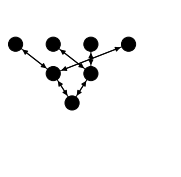

In [40]:
#@title Graph Plotter

import collections
import numpy as np
import networkx as nx
import pylab as plt
%matplotlib inline

def sorted_center(iterable, reverse=False, key=None, select=None):
    centered = []
    s = sorted(iterable, key=key, reverse=reverse)
    front = False
    for v in s:
        if not front:
            centered.append(v)
        else:
            centered.insert(0, v)
        front = not front
    if select:
        return [select(_x) for _x in centered]
    return centered

class GraphPlotter(object):
  
  def __init__(self, graph, ax=None, pos=None):
    if ax is None:
      ax = plt.figure(figsize=(3,3)).gca()
      ax.axis('off')
      ax.set_xlim(0, 1.0)
      ax.set_ylim(0, 1.0)
    
    self._ax = ax
    self._graph = graph
    if pos is None:
      self._pos = dict()
      self.spring_layout()
    else:
      self._pos = pos
      
  @property
  def _base_draw_kwargs(self):
    return dict(G=self._graph, ax=self._ax, pos=self._pos)
 
  def topological_sort(self):
    xlim = self._ax.get_xlim()
    ylim = self._ax.get_ylim()
    
    x = xlim[1] - xlim[0]
    y = ylim[1] - ylim[0]
    xspacer = x * 0.05
    yspacer = y * 0.05
    
    new_xlim = (xlim[0] + xspacer, xlim[1] - xspacer)
    new_ylim = (ylim[0] + yspacer, ylim[1] - yspacer)
    pos = self._topological_sort(self._graph, 
                                 xlim=new_xlim, 
                                 ylim=new_ylim)
    self._pos = pos

  @staticmethod
  def _roots_and_leaves(G, include_cycles=False):
    roots = [k for k, v in G.in_degree(G.nodes) if v == 0]
    leaves = [k for k, v in G.out_degree(G.nodes) if v == 0]
    
    if include_cycles:
      for c in nx.simple_cycles(G):
        outdegree = list(G.out_degree(c))
        outdegree.sort(key=lambda x: x[1])
        leaves.append(outdegree[0][0])

        indegree = list(G.out_degree(c))
        indegree.sort(key=lambda x: x[1])
        roots.append(indegree[0][0])
    return roots, leaves
  
  @classmethod
  def _get_roots(cls, G, include_cycles=False):
    return cls._roots_and_leaves(G, include_cycles=include_cycles)[0]

  @staticmethod
  def _get_leaves(G, include_cycles=False):
    return cls._roots_and_leaves(G, include_cycles=include_cycles)[1]

  @staticmethod
  def _get_subgraphs(graph):
    """Get independent subgraphs"""
    node_list = list(graph.nodes)
    subgraphs = []
    while len(node_list) > 0:
        node = node_list[-1]
        subgraph = nx.bfs_tree(to_undirected(graph), node)
        for n in subgraph.nodes:
            node_list.remove(n)
        subgraphs.append(graph.subgraph(subgraph.nodes))
    return subgraphs

  @classmethod
  def _topological_sort(cls, G, xlim=None, ylim=None):
    if xlim is None:
        xlim = [0.05, 0.95]
    if ylim is None:
        ylim = [0.05, 0.95]
    
    rts = cls._get_roots(G, include_cycles=True)
    max_depth = {}
    for root in rts:
        depths = nx.single_source_shortest_path_length(G, root)
        for n, d in depths.items():
            max_depth[n] = max(max_depth.get(n, d), d)

    by_depth = collections.OrderedDict()

    for node, depth in max_depth.items():
        by_depth.setdefault(depth, [])
        by_depth[depth].append(node)
    
    # center nodes with highest degree
    for depth, nodes in by_depth.items():
        centered = sorted_center(list(G.degree(nodes)), 
                                 key=lambda x: x[1], 
                                 reverse=True,
                                select=lambda x: x[0])
        by_depth[depth] = centered

    # push roots 'up' so they are not stuck on layer one
    for root in rts:
        successors = list(G.successors(root))
        if len(successors) > 0:
            min_depth = min([max_depth[s] for s in successors])
            max_depth[root] = min_depth - 1

    # assign positions

    y_min_max = xlim
    x_min_max = ylim
    max_width = max([len(layer) for layer in by_depth.values()])

    y_step = (y_min_max[1] - y_min_max[0]) / (max(by_depth.keys())+1)
    x_step = (x_min_max[1] - x_min_max[0]) / (max_width )
    positions = {}

    for depth in sorted(by_depth):
        y = y_step * depth + y_min_max[0]
        node_ids = by_depth[depth]
        w = len(node_ids)
        delta_w = max_width - w
        for i, n in enumerate(node_ids):
            x_offset = delta_w * x_step / 2.0
            x = x_min_max[0] + x_offset + i * x_step
            positions[n] = (x, y)
    return positions

  def spring_layout(self, **kwargs):
    pos = nx.spring_layout(self._graph, **kwargs)
    self._pos.update(pos)
    return self._pos
    
  @property
  def nodes(self):
    return self._graph.nodes
  
  @property
  def edges(self):
    return self._graph.edges
  
  def node_attrs(self):
    keys = set()
    for _, node_data in self._graph.nodes(data=True):
      keys.update(set(node_data.keys()))
    attrs = {}
    for _, node_data in self._graph.nodes(data=True):
      for k in keys:
        attrs.setdefault(k, list())
        attrs[k].append(node_data.get(k, None))
    return attrs
  
  def edge_attrs(self):
    keys = set()
    for _, _, edge_data in self._graph.edges(data=True):
      keys.update(set(edge_data.keys()))
    attrs = {}
    for _, _, edge_data in self._graph.edges(data=True):
      for k in keys:
        attrs.setdefault(k, list())
        attrs[k].append(edge_data.get(k, None))
    return attrs
  
  def map_edge_attrs(self, attrs, source, target):
    vals = [self._normalize(self.edge_attrs()[attr], source, target) for attr in attrs]
    return dict(zip(attrs, vals))
  
  def map_node_attrs(self, attrs, source, target):
    vals = [self._normalize(self.node_attrs()[attr], source, target) for attr in attrs]
    return dict(zip(attrs, vals))
  
  def _normalize(arr, source, target):
    x = source[1] - source[0]
    y = target[1] - target[0]
    return [_x/x * y + target[0] for _x in arr] 
  
  def _make_draw_kwargs(self, **kwargs):
    kwargs.update(self._base_draw_kwargs)
    return kwargs
  
  def _draw(self, draw_function, zorder=None, **kwargs):
    draw_kwargs = self._make_draw_kwargs(**kwargs)
    collection = draw_function(**draw_kwargs)
    if collection is not None and zorder is not None:
      try:
        # This is for compatibility with older matplotlib.
        collection.set_zorder(zorder)
      except AttributeError:
        # This is for compatibility with newer matplotlib.
        collection[0].set_zorder(zorder)
    return collection

  def draw_nodes(self, **kwargs):
    """Useful kwargs: nodelist, node_size, node_color, linewidths."""
    if ("node_color" in kwargs and
        isinstance(kwargs["node_color"], collections.Sequence) and
        len(kwargs["node_color"]) in {3, 4} and
        not isinstance(kwargs["node_color"][0],
                       (collections.Sequence, np.ndarray))):
      num_nodes = len(kwargs.get("nodelist", self.nodes))
      kwargs["node_color"] = np.tile(
          np.array(kwargs["node_color"])[None], [num_nodes, 1])
    return self._draw(nx.draw_networkx_nodes, **kwargs)

  def draw_edges(self, **kwargs):
    """Useful kwargs: edgelist, width."""
    return self._draw(nx.draw_networkx_edges, **kwargs)
  
  def draw_graph(self,
                 node_size=200,
                 node_color=(0.4, 0.8, 0.4),
                 node_linewidth=1.0,
                 edge_width=1.0):
    
    node_border_color = (0.0, 0.0, 0.0, 1.0)
    
    # Plot nodes.
    self.draw_nodes(
        nodelist=self.nodes,
        node_size=node_size,
        node_color=node_color,
        linewidths=node_linewidth,
        edgecolors=node_border_color,
        zorder=20)
    # Plot edges.
    self.draw_edges(edgelist=self.edges, width=edge_width, zorder=10)

  
  
g = nx.balanced_tree(2, 2)
g = nx.to_directed(g)

for e in g.edges:
  g.edges[e[0], e[1]]['weight'] = 1
  
ax = plt.figure(figsize=(3,3)).gca()
ax.axis('off')
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
    
plotter = GraphPlotter(g, ax=ax)
plotter.topological_sort()

plotter.draw_graph(node_color=(0, 0, 0), edge_width=plotter.edge_attrs()['weight'])

Synthesized_PlantTF_2020_Campaign__75bf7a05
Fragment_PlantTF_2020_Campaign__cb0e46b1
	Primer_PlantTF_2020_Campaign__1984a29f
	Primer_PlantTF_2020_Campaign__264b4aeb
	pYTK017
Fragment_PlantTF_2020_Campaign__4fd29fa6
	M13-pGREEN_H-r
	Primer_PlantTF_2020_Campaign__d2a070e2
	pMOD8-pGALz4-yeGFP
Fragment_PlantTF_2020_Campaign__ffcf7c21
	j5_0309_(T154Sc)_reverse
	Primer_PlantTF_2020_Campaign__c945a6eb
	pMOD-HOkan-pGRR-W34-RGR-W20
Fragment_PlantTF_2020_Campaign__d686e789
	TP_f
	j5_0309_(T154Sc)_reverse
	pMOD-HOkan-pGRR-W34-RGR-W20
Synthesized_PlantTF_2020_Campaign__75bf7a05
Synthesized_PlantTF_2020_Campaign__19b58fa8
MISSING ASSEMBLY FOR dict_keys(['compiled', 'run', 'success', 'assemblies', 'record', 'sequence'])
Fragment_PlantTF_2020_Campaign__cb0e46b1
	Primer_PlantTF_2020_Campaign__1984a29f
	Primer_PlantTF_2020_Campaign__264b4aeb
	pYTK017
Fragment_PlantTF_2020_Campaign__40bf752f
	Primer_PlantTF_2020_Campaign__b71f4188
	j5_0309_(T154Sc)_reverse
	pMOD-HOkan-pGRR-W34-RGR-W20
Fragment_PlantTF_2

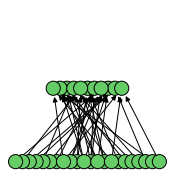

In [ ]:
from pydent import Planner
import networkx as nx
%matplotlib inline

g = nx.DiGraph()
for qk, d in results['designs'].items():
    if not len(d['assemblies']):
        print("MISSING ASSEMBLY FOR {}".format(d.keys()))
        continue
    reaction_id = d['assemblies'][0]['final_assembly_reaction'][0]
    
    assembly_reaction = results['reactions'][reaction_id]
    in_samples = [results['molecules'][i]['__sample__'] for i in assembly_reaction['inputs']]
    out_samples = [results['molecules'][i]['__sample__'] for i in assembly_reaction['outputs']]
    print(out_samples[0].name)
    for s in in_samples:
        print('\t{}'.format(s.name))
        
        g.add_edge(s.name, out_samples[0].name)

plotter = GraphPlotter(g)
plotter.topological_sort()

plotter.draw_graph()
plt.show()

### Save the inventory!

In [70]:
for s in new_samples:
    print(s.field_values)

[<pydent.models.field_value.FieldValue object at 0x7f9e7e043900>, <pydent.models.field_value.FieldValue object at 0x7f9e84f65580>, <pydent.models.field_value.FieldValue object at 0x7f9e7e043540>]
[<pydent.models.field_value.FieldValue object at 0x7f9e84179fc0>, <pydent.models.field_value.FieldValue object at 0x7f9e864884c0>, <pydent.models.field_value.FieldValue object at 0x7f9e841797c0>]
[<pydent.models.field_value.FieldValue object at 0x7f9e7ca10100>, <pydent.models.field_value.FieldValue object at 0x7f9e7e0433c0>, <pydent.models.field_value.FieldValue object at 0x7f9e75c65980>]
[<pydent.models.field_value.FieldValue object at 0x7f9e85c62640>, <pydent.models.field_value.FieldValue object at 0x7f9e86488540>, <pydent.models.field_value.FieldValue object at 0x7f9e74da2a80>]
[<pydent.models.field_value.FieldValue object at 0x7f9e74da2880>, <pydent.models.field_value.FieldValue object at 0x7f9e77339f00>]
[<pydent.models.field_value.FieldValue object at 0x7f9e7fc63ac0>, <pydent.models.fiel

In [75]:
import pydent
pydent.__version__

'1.0.2'

In [85]:
def save_sample(s):
    existing = s.session.Sample.find_by_name(s.name)
    if not existing:
        s.save()
    else:
        s.id = existing.id
    for fv in s.field_values:
        if fv.sample:
            save_sample(fv.sample)

In [86]:
with session(using_cache=False) as sess:

    for s in new_samples:
        existing = sess.Sample.find_by_name(s.name)
        if existing:
#             print(existing.name)
            s.id = existing.id
        else:
            print('saving {}'.format(s.name))
            save_sample(s)
#             save_inventory(session, [s], merge_samples=True)
#         if existing:
#             s.id = existing.id
#             s.reload(existing.dump())
#         else:
#             print(s.field_values)

saving Fragment_PlantTF_2020_Campaign__23d83be1
saving Fragment_PlantTF_2020_Campaign__706b91fe
saving Fragment_PlantTF_2020_Campaign__5c9538dc
saving Primer_PlantTF_2020_Campaign__e5d4d0d9
saving pMOD8_Backbone_strong_exp_strong_ad_tet
saving Fragment_PlantTF_2020_Campaign__ede7d5a7
saving pMOD8_Backbone_weak_exp_strong_ad_tet
saving Fragment_PlantTF_2020_Campaign__3d2a2a55
saving Primer_PlantTF_2020_Campaign__2fd20a38
saving pMOD8_Backbone_strong_exp_strong_ad_zev
saving Fragment_PlantTF_2020_Campaign__1be71d34
saving pMOD8_Backbone_weak_exp_strong_ad_zev
saving Fragment_PlantTF_2020_Campaign__9f01e52f
saving Synthesized_PlantTF_2020_Campaign__0629d7b0
saving pMOD8_Backbone_weak_exp_med_ad_zev
saving Fragment_PlantTF_2020_Campaign__2d4ac560
saving Fragment_PlantTF_2020_Campaign__0748cceb
saving Primer_PlantTF_2020_Campaign__eaa75104
saving Synthesized_PlantTF_2020_Campaign__acc1d7cd
saving pMOD-HO-KanMX_output_node_4b2_anac102_stable_gfp
saving Fragment_PlantTF_2020_Campaign__ffcf7c2

In [113]:
for s in new_samples:
    try:
        save_inventory(session, [s])
    except Exception as e:
        print(e)

Error response:
Name The sample name 'Primer_PlantTF_2020_Campaign__d2a070e2' is the name of an existing sample
Error response:
Name The sample name 'Primer_PlantTF_2020_Campaign__eadfa9cf' is the name of an existing sample
Error response:
Name The sample name 'Primer_PlantTF_2020_Campaign__8c23e3a9' is the name of an existing sample
Error response:
Name The sample name 'Primer_PlantTF_2020_Campaign__a644cb82' is the name of an existing sample
Error response:
Name The sample name 'Primer_PlantTF_2020_Campaign__ce47cb71' is the name of an existing sample
Error response:
Name The sample name 'Primer_PlantTF_2020_Campaign__264b4aeb' is the name of an existing sample
Error response:
Name The sample name 'Primer_PlantTF_2020_Campaign__264b4aeb' is the name of an existing sample
Error response:
Name The sample name 'Primer_PlantTF_2020_Campaign__e5d4d0d9' is the name of an existing sample
Error response:
Name The sample name 'Primer_PlantTF_2020_Campaign__e5d4d0d9' is the name of an existing

In [141]:
with session(using_cache=False) as sess:
    sample = session.Sample.find(34866)
    print(sample.properties)

{'Sequence': 'GCGGCCGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGGAGGAGTCTAGAAAGCTTGATATCGAATTCCTGCAGCCCGGGTACTGTATGTACATACAGTAGGATCCTATGGCATGCATGTGCTCTGTATGTATATAAAACTCTTGTTTTCTTCTTTTCTCTAAATATTCTTTCCTTATACATTAGGACCTTTGCAGCATAAATTACTATACTTCTATAGACACACAAACACAAATACACACACTAATCTAGATATTAAAATGTCTAAAGGTGAAGATGGCGGAATTAATTCCCGAGCCTCCAAAAAAGAAGAGAAAGGTCGAATTGGGTACCGCCACCGGTGAAGTTTTCGAGTTTGAGTATTTGGACGATAAGGTTCTTGAAGAACTTCTTGATTCAGAAGAAAGGAAGAGAGAAGTTTTCGAGTTTGAGTATTTGGACGATAAGGTTCTTGAAGAACTTCTTGATTCAGAAGAAAGGAAGAGAAGTGGCGAAGGTAACTTAGGTAAGGATCATGAAGAAGAAAACGAAGCACCACTTCCTGGGTTCAGGTTTCATCCGACGGATGAAGAGCTTTTAGGATACTATCTTCGAAGAAAAGTAGAGAACAAAACCATCAAACTCGAACTTATCAAACAGATCGATATCTATAAGTACGATCCTTGGGATCTTCCAAGAGTGAGCAGCGTCGGAGAAAAGGAGTGGTACTTCTTCTGCATGAGAGGTAGGAAATACAGGAATAGCGTTCGACCAAACCGAGTGACCGGTTCAGGTTTCTGGAAAGCCACTGGTATTGATAAACCGGTTTACTCCAATCTTGACTGTGTTGGTCTCAAGAAATCTCTGGTTTACTATCTTGGTTCAGCCGGTAAAGGCACCAAAACCGATTGGATGATGCATGAATTCCGCCTCCCCTCCACCACGAAAACCGACTCTCCAGCTCAAC

In [139]:
session.Sample.find_by_name('pMOD6_backbone_Input_node_be_jub1').field_values

In [ ]:
def props(s):
    if not s.field_values:
        return {}
    data = s.properties
    for k, v in data.items():
        if v.__class__.__name__ == 'Sample':
            data[k] = v.id
    return data
            
def validate_samples(new_samples):
    with session(using_cache=False) as sess:
        for s1 in new_samples:
            print(s1.name)
            s2 = sess.Sample.find_by_name(s1.name)
            if not s2:
                print("{} not saved!".format(s1.name))
                continue
            if s1.id != s2.id:
                print("{} != {}".format(s1.id, s2.id))
            d1 = props(s1)
            d2 = props(s2)
            d = list(dictdiffer.diff(d1, d2))
 
            if d:
                for _d in d:
                    print(_d)
                return

validate_samples(new_samples)

In [125]:
import dictdiffer

dictdiffer.diff?

Signature:
dictdiffer.diff(
    first,
    second,
    node=None,
    ignore=None,
    path_limit=None,
    expand=False,
    tolerance=2.220446049250313e-16,
    dot_notation=True,
)
Docstring:
Compare two dictionary/list/set objects, and returns a diff result.

Return an iterator with differences between two objects. The diff items
represent addition/deletion/change and the item value is a *deep copy*
from the corresponding source or destination objects.

>>> from dictdiffer import diff
>>> result = diff({'a': 'b'}, {'a': 'c'})
>>> list(result)
[('change', 'a', ('b', 'c'))]

The keys can be skipped from difference calculation when they are included
in ``ignore`` argument of type :class:`collections.Container`.

>>> list(diff({'a': 1, 'b': 2}, {'a': 3, 'b': 4}, ignore=set(['a'])))
[('change', 'b', (2, 4))]
>>> class IgnoreCase(set):
...     def __contains__(self, key):
...         return set.__contains__(self, str(key).lower())
>>> list(diff({'a': 1, 'b': 2}, {'A': 3, 'b': 4}, ignore=

In [102]:
save_inventory(session, [s])

[]

In [97]:
s.field_values[0].dump()

{'role': None,
 'parent_id': 34883,
 'value': 'AGTGTCCCTTAACCAGATTCGAAAAGCGGCCCTTAACCAGATTCGAAAAGCGGCTGCCGTGTCCTTCCCGCTGCCATTCTTCCAGACGGGGCTTCGGTCAGGTGCGCCGTGACTTCCCCGTCGCGGTCTATGAGCCTCGGGTTGGTAAAAACTTAAGCTTGATATCGAATTCCTGCAGCCCGGGTACTGTATGTACATACAGTAGGATCCTATGGCATGCATGTGCTCTGTATGTATATAAAACTCTTGTTTTCTTCTTTTCTCTAAATATTCTTTCCTTATACATTAGGACCTTTGCAGCATAAATTACTATACTTCTATAGACACACAAACACAAATACACACACTAATCTAGATATTAAAATGTCTAAAGGTGAAGATGGTCTCTAAGGGTGAAGAATTGTTCACCGGTGTCGTCCCAATCTTGGTCGAATTGGACGGGGACGTCAACGGTCACAAGTTCTCTGTCTCTGGTGAAGGTGAAGGTGACGCTACCTACGGTAAGTTGACCTTGAAGTTCATCTGTACCACCGGTAAGTTGCCAGTCCCATGGCCAACCTTGGTCACCACCTTCGGTTACGGTGTCCAATGTTTCGCTAGATACCCAGACCACATGAAGCAACACGACTTCTTCAAGTCTGCTATGCCAGAAGGTTACGTCCAAGAAAGAACCATCTTCTTCAAGGACGACGGTAACTACAAGACCAGAGCTGAAGTCAAGTTCGAAGGTGACACCTTGGTCAACAGAATCGAATTGAAGGGTATCGACTTCAAGGAAGACGGTAACATCTTGGGTCACAAGTTGGAATACAACTACAACTCTCACAACGTCTACATCATGGCTGACAAGCAAAAGAACGGTATCAAGGTCAACTTCAAGATCAGACACAACATCGAAGACGGTTCTGTCCAATTGGCTGACCACTACCAACAAAACACCCCAATCGGTGACG

In [91]:
for s in new_samples:
    if s.name == 'Fragment_PlantTF_2020_Campaign__2d4ac560':
        print("FUCK YOU")
        print(s)

FUCK YOU
<Sample id=None name=Fragment_PlantTF_2020_Campaign__2d4ac560 sample_type={'rid': 49802, 'id': 4, 'name': 'Fragment', 'description': 'A linear double stranded piece of DNA from PCR or Restriction Digest', 'created_at': '2013-10-16T14:33:41.000-07:00', 'updated_at': '2015-11-29T07:55:20.000-08:00', 'field_types': [{'name': 'Sequence', 'ftype': 'url', 'array': False, 'choices': None, 'role': None, 'preferred_field_type_id': None, 'preferred_operation_type_id': None, 'required': True, 'routing': None, 'parent_class': 'SampleType', 'parent_id': 4, 'sample_type': None, 'operation_type': None, 'allowable_field_types': [], 'rid': 49773, 'id': 11, 'part': None, 'created_at': '2016-05-09T20:40:31.000-07:00', 'updated_at': '2016-05-09T21:17:39.000-07:00'}, {'name': 'Length', 'ftype': 'number', 'array': False, 'choices': None, 'role': None, 'preferred_field_type_id': None, 'preferred_operation_type_id': None, 'required': True, 'routing': None, 'parent_class': 'SampleType', 'parent_id': 4

## Validation Checks

In [42]:
# check if updating samples exist

exists = []
for u in to_update:
    print(u.id)
    existing = session.Sample.find_by_name(u.name)
    if existing:
        print('{} exists'.format(u.name))
        exists.append(existing)
        
if exists:
    raise ValueError
#     assert not session.Sample.find_by_name(u.name)

### Double Check Sample Properties

In [110]:
for s in all_samples:
    print('{}: {}'.format(s.id, s.name))
    for fv in s.field_values:
        if fv.sample:
            print('\t{}: {}: {}'.format(fv.name, fv.sample.id, fv.sample.name))
        elif fv.value:
            if isinstance(fv.value, str):
                if len(fv.value) > 80:
                    v = fv.value[:80] + "..."
                else:
                    v = fv.value
            else:
                v = fv.value
            print('\t{}: {}'.format(fv.name, v))

34866: pMOD6_backbone_Input_node_be_jub1
	Sequence: GCGGCCGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGG...
	Length: 6073.0
	Bacterial Marker: Amp
34867: pMOD6_backbone_Input_node_be_ataf1
	Sequence: GCGGCCGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGG...
	Length: 6115.0
	Bacterial Marker: Amp
34868: pMOD6_backbone_Input_node_be_ant
	Sequence: GCGGCCGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGG...
	Length: 6913.0
	Bacterial Marker: Amp
34869: pMOD6_backbone_Input_node_be_anac102
	Sequence: GCGGCCGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGG...
	Length: 6565.0
	Bacterial Marker: Amp
34870: Synthesized_PlantTF_2020_Campaign__75bf7a05
	Sequence: GCGGCCGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGGAGGAGGAGCGGCGGAGGAGTGCGGCGG...
	Length: 526.0
34871: pMOD6_backbone_Input_node_doxy_jub1
	Sequence: TCCCTATCAGTGATAGAGAACGTATGTCGAGTTTACTCCCTATCAGTGATAGAGAACGTATGTCGAGTTTACTCCCTATC..

In [ ]:
# save updating samples
# if not exists:
#     for s in tqdm(to_update):
#         try:
#             s.save()
#         except Exception:
#             print("Failed to save {}: {}".format(s.id, s.name))